# Grid Simulation of a Concentrator Solar Cell

This example, walksthrough the how to use the classes and function in `solcore.spice` to simulate different grid structures of concentrator solar cell. We are going to preproduce some of the figures published by Steiner et al. [1]

## References
[1] M. Steiner et al., Validated front contact grid simulation for GaAs solar cells under concentrated sunlight, Progress in Photovoltaics, Volume 19, Issue 1, January 2011, Pages 73-83. DOI: 10.1002/pip.989


# Grid Pattern

The `solcore.spice.grid.HGridPattern` class can generate different grid metalisation patterns. Let's see what this class can do.

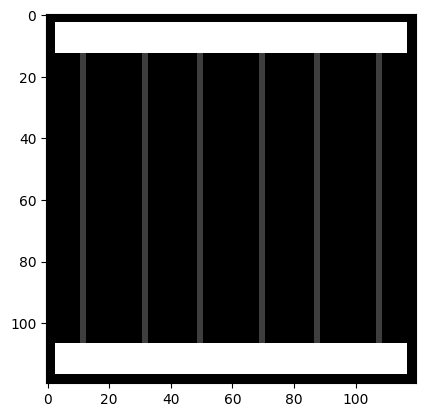

In [17]:
from solcore.spice.grid import HGridPattern
import matplotlib.pyplot as plt

bus_px = 10
fingers_px =  [4, 4, 4, 4, 4, 4]
offset_px = 3
nx, ny = 120, 120
grid = HGridPattern(bus_px, fingers_px, offset_px=offset_px, nx=nx, ny=ny)
plt.imshow(grid.as_array(), cmap="gray")


This grid pattern always has two bus bars on the top and bottom, the size of the bus bar in the y-direction is specified by `bus_px`, in this case 10 pixels.

The metalisation does not extend all the way to the edges of the solar cell, this offset is specfied by `offset_px`, in this case 3 pixels.

Grid fingers are always equally spaced, the number and width of grid fingers is specified by an array of pixel widths, this is a required argument. In this case there six finger all of width 4 pixels.

The size of the image is specified by the `nx` and `ny` which sets the number of pixels in the x and y directions, respectively.

Some useful methods:
 * `as_array()`
 * `save_as_image()`

We have already seen `as_array()` used to plot the image above.

In [6]:
grid.as_array()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

To save the image to disk use `save_as_image()`.

In [7]:
grid.save_as_image("demo_grid.png")

We can tell the notebook to render this image from disk.

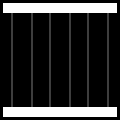

In [12]:
from IPython.display import display
from PIL import Image
display(Image.open("demo_grid.png"))

## Colour scheme convention

The colors in the image have specific meaning to the solcore:

* White is a bus bar
* Gray is a grid finger (50%)
* Black is an absence of any metal

In code to follow, we will be sweeping out an IV curve for this solar cell. The distinction between bus bar and grid finger is that former is connect directly to the bias voltage source that is sweep to calculate the characteristic curve.

# Create a netlist

A netlist describes the elements and connections between them in the SPICE simulation. We are going to use the helper function to generate this netlist for us given some high-level input parameters that describe our the solar cell.

The basic structure of the function we will use looks like this,

```python
    temperature = 300.0
    netlist = generate_netlist(
        grid,
        illumination_map,
        size,
        junctions,
        temperature=temperature
    )
```

We have already seen the first argument `grid` let's take a look at the others.

The `illumination_map` is a 2D array, the same size and grid image, that contains relative intensity of illumination across the surface of the solar cell. A value of 1 means the intensity is at maximum value, and value of zero means no illumination intensity at all. Moreover, to simulate entirely uniform illumination we just need to create an array of ones.

```python
    import numpy as np
    illumination_map = np.ones((nx, ny))
```

The next argument is size, this is a tuple of width (x-direction) and length (y-direction) of solar cell. Here, the solar cell we want to simulate is approximately 3mm by 3mm, therefore,

```python
size = (0.003, 0.003)  # specifc size this in meters
```

Finally, junctions is list of Python dictionaries containing information about each junciton in the solar cell,

```python
    junctions = [
            {
                "jsc": jsc,
                "emitter_sheet_resistance": 100.0,
                "j01": 4e-16,
                "j02": 2e-7,
                "Eg": 1.41,
                "n1": 1.0,
                "n2": 2.0
            }
        ]
```

The parameters are:
   * `jsc`, the short-circuit current generate by the junction in A / m2.
   * `emitter_sheet_resistance` the sheet resistance of the emitter region in Ohm per square.
   * `j01`, the saturation current density in neutral region in A / m2.
   * `j02`, the saturation current density in the bulk region in A / m2.
   * `Eg`, the bandgap of the material in eV (this one is no SI units!).
   * `n1`, the ideality factor of the `j01` diode, default is 1.
   * `n2`, the ideality factor of the `j02` diode, default is 2.

Note a shunt resistance is not currently included in this modelling because it is aimed a concentrator solar cells and so large as to be ignoreable.

Let's actually generate the netlist.

In [24]:
import numpy as np
from solcore.spice.netlist import generate_netlist


# Homogeneous illumination
illumination_map = np.ones(nx * ny).reshape((nx, ny))

# The size of the solar is 3mm x 3mm
size = (0.003, 0.003) # meters

# Define a list of properies that describe each junction in the solar cell.
# NB: currently only one junction is working.
junctions = [
    {
        "jsc": 30000,
        "emitter_sheet_resistance": 100.0,
        "j01": 4e-16,
        "j02": 2e-7,
        "Eg": 1.41,
        "n1": 1.0,
        "n2": 2.0
    }
]

temperature = 300.0

netlist = generate_netlist(
    grid,
    illumination_map,
    size,
    junctions,
    temperature=temperature
)

# preview some of text
print(netlist[:500])


        * HEADER
        .options TNOM=26.850000000000023 TEMP=26.850000000000023
        vin in 0 DC 0
        
        * HEADER
        .model __D1_0 D(is=2.5e-25,n=1.0,eg=1.41)
        .model __D2_0 D(is=1.2499999999999999e-16,n=2.0,eg=1.41)
        
        * BUS
        R_METAL_X1_3_3_0 NX_3_3_0 in 0.0058333333333333345
        R_METAL_X2_3_3_0 in NX_4_3_0 0.0058333333333333345
        R_METAL_Y1_3_3_0 NY_3_3_0 in 0.0058333333333333345
        R_METAL_Y2_3_3_0 in NY_3_4_0 0.005833333333333


As you can seet the netlist is just a string. The detail of the netlist are not important for this tutorial, so we will move on.

# Solve the netlist

SPICE must digest the netlist and solve it. The result is voltages at all nodes and current through all elements. We need to specific a voltage range and step size when calling the solver function. Note, depending on the size of the netlist this could take varying amount of time to solve. At the time of writing this take about a minute on a modern laptop.

In [25]:
from solcore.spice.netlist import solve_netlist
v_start = -0.1
v_stop = 1.5
v_step = 0.01
result = solve_netlist(netlist, temperature, v_start, v_stop, v_step)

# Getting useful data from the result object

A result is returned which can be passed to helper function to get the information we want, these can be found in the module `solcore.spice.result`. Let's import the functions to help get and plot the IV curve.

## IV Curve

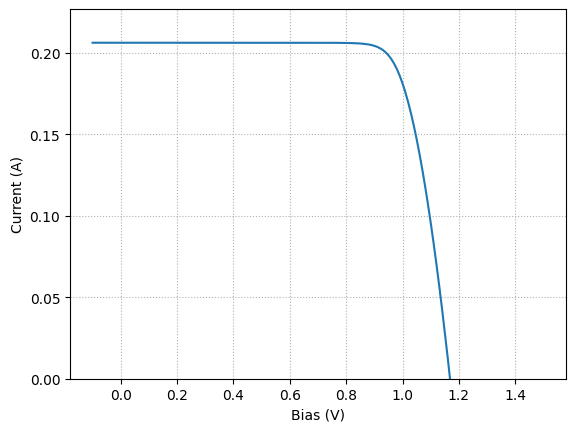

In [36]:
from solcore.spice.result import get_characterisic_curve, plot_characteristic_curve

v, i = get_characterisic_curve(result)
plot_characteristic_curve(v, i)


## Maximum power point

Let's get the maximum power point information.

In [27]:
from solcore.spice.result import get_maximum_power_point
vmax, pmax, maxidx = get_maximum_power_point(result)
print(vmax, pmax, maxidx)

0.9500000000000006 0.1884503672066743 105


Here `vmax` and `pmax` are the voltage and power at the maximum power point. 

`maxidx` is the index in bias voltage array the corresponds to the maximum power points. For example,

In [28]:
v[maxidx] == vmax

True

## Layer voltages

We can make nice plots of surface voltages using the following functions,

In [34]:
from solcore.spice.result import get_node_voltages, plot_surface_voltages

voltages = get_node_voltages(result)
voltages.shape

(120, 120, 3, 161)

Here `voltages` is a 3 + 1 dimensional array. The first three dimensions correspond to the physical x, y, z location in the discretisation and the last dimension corresponds to the number of steps in the voltage sweep.

The first z index is the metal layer, the second z index is the pv (emitter) layer and the third is the base and buffer layer.

The helper function plots both the metal and the pv layer voltages.

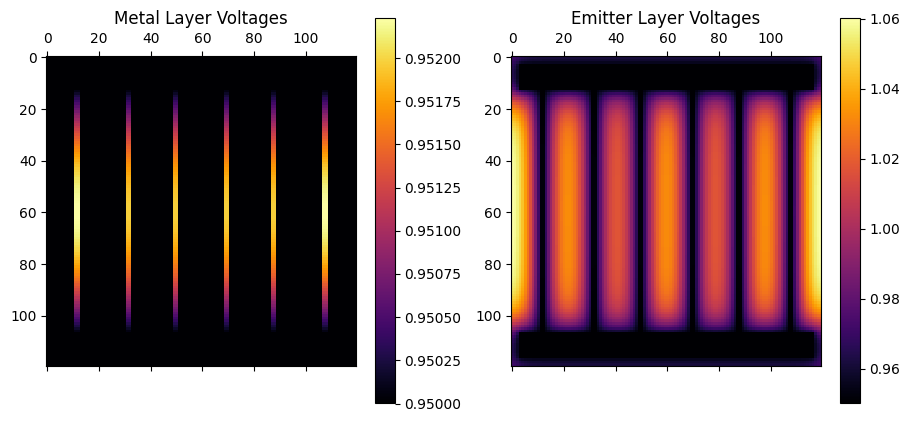

In [35]:
plot_surface_voltages(voltages, bias_index=maxidx)

# Electroluminescence prediction
We can make a prediction of the electroluminescene distribution emitter by the solar cells using the following helper functions,

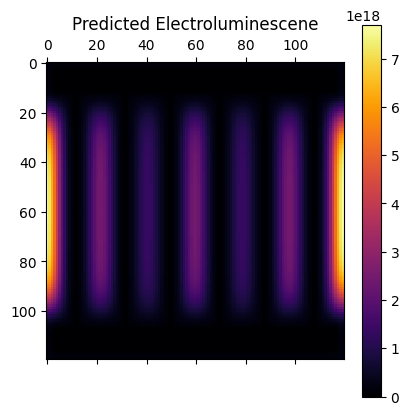

In [39]:
from solcore.spice.result import get_electroluminescence, plot_electroluminescence

pv_layer_idx = 1  # index = 1 is the PV layer
pv_layer_voltages = voltages[:, :, pv_layer_idx, maxidx]
el = get_electroluminescence(pv_layer_voltages, is_metal=grid.is_metal)
plot_electroluminescence(el)

# A more detailed example using solcore to calculate the short-circuit current

Let's create a solcore solar cell model based on the solar cell structure above and get it to calculate the short-circuit current.

In [42]:
from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.solar_cell_solver import solar_cell_solver
from solcore.light_source import LightSource

def get_jsc(concentrationX):
    junction_model = Junction(
        kind='2D',
        T=temperature,
        reff=1,
        jref=300,
        Eg=1.4,
        A=1,
        R_sheet_top=100,
        R_sheet_bot=1e-16,
        R_shunt=1e16,
        n=3.5
    )

    solar_cell_model = SolarCell([junction_model], T=temperature)
    wl = np.linspace(350, 2000, 301) * 1e-9
    light_source = LightSource(
        source_type="standard",
        version="AM1.5g",
        x=wl,
        output_units="photon_flux_per_m",
        concentration=concentrationX
    )

    options = {
        "light_iv": True,
        "wavelength": wl,
        "light_source": light_source,
        "optics_method": "BL"
    }
    solar_cell_solver(solar_cell_model, 'iv', user_options=options)

    jsc = solar_cell_model(0).jsc
    return jsc

# Get the JSC for 100x concentration
get_jsc(100)

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


32491.025503548084

Make a second function that wraps the SPICE model and returns efficiency of the device. Inside this function it calls solcore to estimate the JSC.

In [47]:
def get_efficiency(concentrationX, power_in=1000.0):
    
    bus_px = 10
    fingers_px =  [4, 4, 4, 4, 4, 4]
    offset_px = 3
    nx, ny = 120, 120
    grid = HGridPattern(bus_px, fingers_px, offset_px=offset_px, nx=nx, ny=ny)

    # Homogeneous illumination
    illumination_map = np.ones(nx * ny).reshape((nx, ny))

    # The size of the solar is 3mm x 3mm
    size = (0.003, 0.003) # meters

    # Define a list of properies that describe each junction in the solar cell.
    # NB: currently only one junction is working.
    junctions = [
        {
            "jsc": get_jsc(concentrationX),  # solcore is calculating this for us!
            "emitter_sheet_resistance": 100.0,
            "j01": 4e-16,
            "j02": 2e-7,
            "Eg": 1.41,
            "n1": 1.0,
            "n2": 2.0
        }
    ]

    temperature = 300.0

    netlist = generate_netlist(
        grid,
        illumination_map,
        size,
        junctions,
        temperature=temperature
    )

    result = solve_netlist(netlist, temperature, 0.0, 1.5, 0.01)

    vmax, pmax, maxidx = get_maximum_power_point(result)
    
    p_per_m2 = pmax / size[0] / size[1]
    efficiency = p_per_m2 / (concentrationX * power_in)
    return efficiency


Finally, let's loop over a few concentration values to see if we can plot a concentration vs efficiency plot.

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


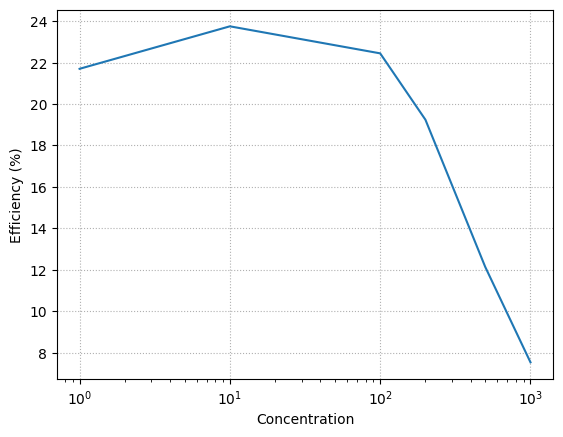

In [49]:
effs = list()
x_values = [1, 10, 100, 200, 500, 1000]
for x in x_values:
    effs.append(get_efficiency(x))

plt.semilogx(x_values, 100 * np.array(effs))
plt.grid(linestyle="dotted")
plt.xlabel("Concentration")
plt.ylabel("Efficiency (%)")
plt.show()